In [95]:
import wfdb
from scipy import signal
import scipy
import numpy as np
from matplotlib import pyplot as plt
import math

In [96]:
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(input_signal, low_cutoff, high_cutoff, sampling_rate, order):
    nyq = 0.5 * sampling_rate
    low = low_cutoff / nyq
    high = high_cutoff / nyq
    numerator, denominator = butter(order, [low, high], btype='band', output='ba', analog=False, fs=None)
    filtered = filtfilt(numerator, denominator, input_signal)
    return filtered

def smoothMAconv(depth,temp, scale): # Moving average by numpy convolution
    dz = np.diff(depth) 
    N = int(scale/dz[0])
    smoothed=np.convolve(temp, np.ones((N,))/N, mode='same') 
    return smoothed

def get_onset_offset(X, Y, signal):
    a_norm = math.sqrt((Y[0]-X[0])**2 + (Y[1]-X[1])**2)
    
    a = np.array([[X[0], X[1]], [Y[0], Y[1]]])

    c_x = X[0]
    prev_sigma_max = -1
    max_x = -1
    while True:
        if X[0] > Y[0]:
            if c_x <= Y[0]:
                return max_x
            c_x -= 1
        else:
            if c_x >= Y[0]:
                return max_x
            c_x += 1
        
        c = np.array([[X[0], X[1]], [c_x, signal[int(c_x)]]])
        
        ac_cross = np.cross(a, c)
        m_cross = (a[0][0]-a[1][0]) * (c[0][1]-c[1][1]) - (a[0][1]-a[1][1]) * (c[0][0]-c[1][0])
        
        ac_norm = np.linalg.norm(ac_cross)
        sigma = ac_norm / a_norm
        if X[0] > Y[0]:
            sigma = m_cross
        else:
            sigma = -m_cross

        if sigma > prev_sigma_max:
            prev_sigma_max = sigma
            max_x = int(c_x)



# Read Record

In [97]:
# TODO: Read all records for patients. Save fiducial features for each record/patient

samp_start = 1300+700
samp_end = 3200+1400
fs = 1000
time = (samp_end - samp_start) / fs
# best start = 1300, best end = 3200
record = wfdb.rdrecord('../01.Dataset/117/s0291lre', channels=[1])

yraw = record.p_signal[:, 0]
time = len(yraw) / fs

# Get Fiducial Features

In [98]:
# STEPS 1 to 4

# 1. Bandpass (low pass / high pass)
y_lfiltered = butter_bandpass_filter(record.p_signal[:, 0], low_cutoff=1.0, high_cutoff=40.0, sampling_rate=1000, order=2)
denoised_signal = y_lfiltered

# 2. Differentiation
y_lfiltered = np.gradient(y_lfiltered)

# 3. Squaring
y_lfiltered = y_lfiltered ** 2

# 4. Window smoothing
n = 40
y_lfiltered=np.convolve(y_lfiltered, np.ones((n,))/n, mode='same')

# Resize for next processing
y_lfiltered = y_lfiltered * 1000
window_smoothed_signal = y_lfiltered.copy()

In [99]:
# Reduce all values close to zero to be zero
y_lfiltered[y_lfiltered < 0.1] = 0

# Get Q and S
qx = []; qy = []
sx = []; sy = []
qrs_state = False

for i in range(len(y_lfiltered)):
    if not qrs_state:
        if y_lfiltered[i] != 0:
            qx.append(i)
            qy.append(denoised_signal[i])
            qrs_state = True
    else:
        if y_lfiltered[i] == 0:
            sx.append(i)
            sy.append(denoised_signal[i])
            qrs_state = False

# Remove invalid QRS (Incomplete QRS)
if qrs_state != False:
    idx = qx.pop()
    for i in range(idx, len(y_lfiltered)):
        y_lfiltered[i] = 0
    qy.pop()

# Fix s and q (Crawl towards correct value)
for i in range(len(qx)):
    idx = qx[i]
    while(True):
        if denoised_signal[idx-1] < denoised_signal[idx]:
            qx[i] = idx-1
            qy[i] = denoised_signal[idx-1]
        else:
            break
        idx -= 1
    idx = qx[i]
    while(True):
        if denoised_signal[idx+1] < denoised_signal[idx]:
            qx[i] = idx+1
            qy[i] = denoised_signal[idx+1]
        else:
            break
        idx += 1

for i in range(len(sx)):
    idx = sx[i]
    while (True):
        if denoised_signal[idx-1] < denoised_signal[idx]:
            sx[i] = idx-1
            sy[i] = denoised_signal[idx-1]
        else:
            break
        idx -= 1
    idx = sx[i]
    while (True):
        if denoised_signal[idx+1] < denoised_signal[idx]:
            sx[i] = idx+1
            sy[i] = denoised_signal[idx+1]
        else:
            break
        idx += 1


qx = np.array(qx); qy = np.array(qy)
sx = np.array(sx); sy = np.array(sy)

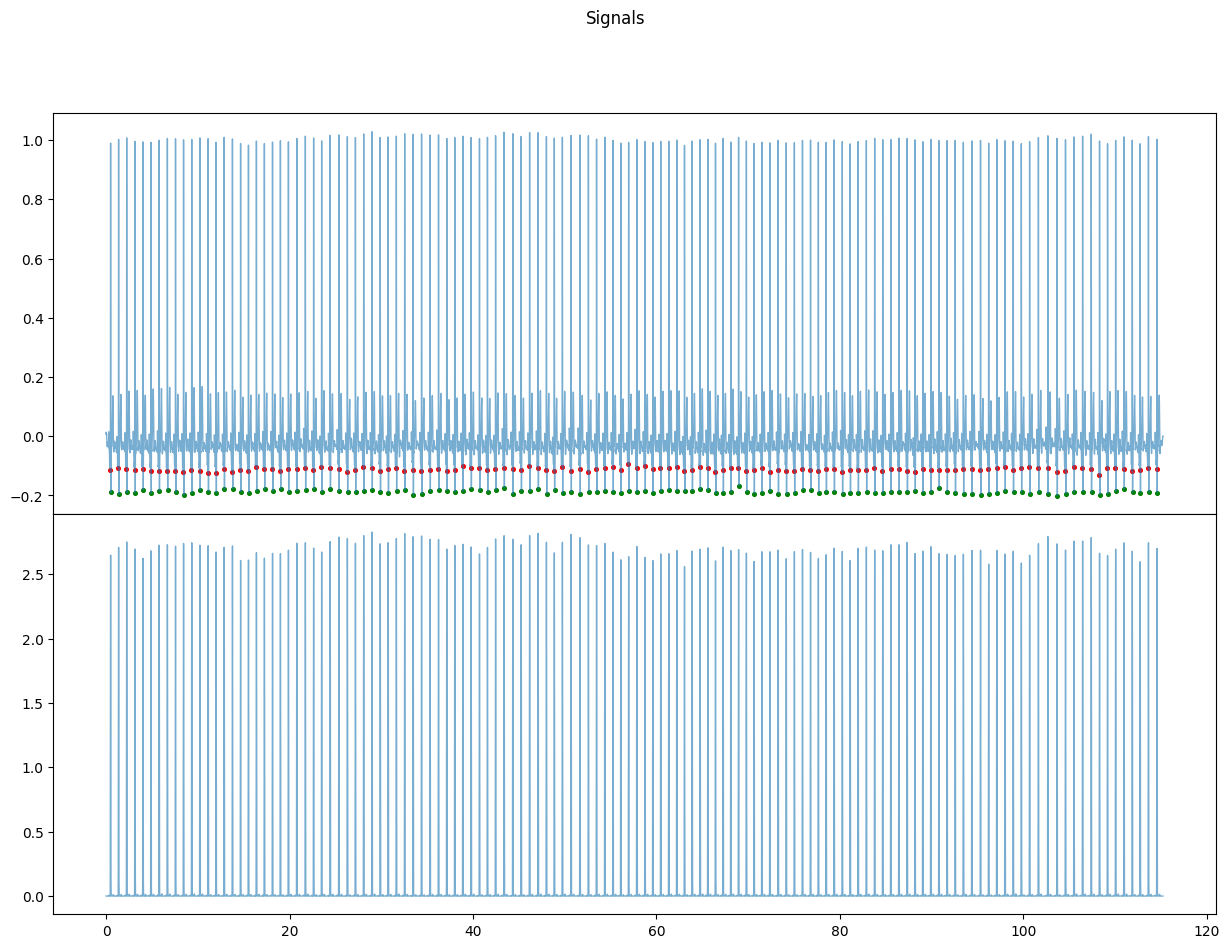

In [100]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, window_smoothed_signal, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
#axs[0].scatter(Rx/fs, Ry, color="blue", s=7)

In [101]:
# 5. Thresholding (Get R, any value not the peak between Q and S is set to 0)
for i in range(len(qx)):
    y_lfiltered[qx[i]:sx[i]][y_lfiltered[qx[i]:sx[i]] != max(y_lfiltered[qx[i]:sx[i]])] = 0


print("Q: ")
print("-X: " + str(qx) + " - Y: " + str(qy))
print("S: ")
print("-X: " + str(sx) + " - Y: " + str(sy))
print(sx.shape)

# 6. Remove any peaks that are not Rs
y_lfiltered[y_lfiltered < max(y_lfiltered) * 0.7] = 0

# Retrieve R
Rx = []
Ry = []
for i in range(len(y_lfiltered)):
    if y_lfiltered[i] != 0:
        Rx.append(i)
        Ry.append(denoised_signal[i])

# Fix R (Crawl to correct value)
for i in range(len(Rx)):
    idx = Rx[i]
    while (True):
        if denoised_signal[idx-1] > denoised_signal[idx]:
            Rx[i] = idx-1
            Ry[i] = denoised_signal[idx-1]
        else:
            break
        idx -= 1
    idx = Rx[i]
    while (True):
        if denoised_signal[idx+1] > denoised_signal[idx]:
            Rx[i] = idx+1
            Ry[i] = denoised_signal[idx+1]
        else:
            break
        idx += 1

Rx = np.array(Rx)
Ry = np.array(Ry)

print("R:")
print("Rx: " + str(Rx) + " - Ry: " + str(Ry))

# Get QRS onset and offset
qrs_off_x = []; qrs_on_x = []
qrs_off_y = []; qrs_on_y = []
for x in Rx:
    X = np.array([x, window_smoothed_signal[x]])
    Y = np.array([x-300, window_smoothed_signal[x-300]])
    #print(X[1])
    #print(get_onset_offset(X, Y, window_smoothed_signal))
    qrs_on_x.append(get_onset_offset(X, Y, window_smoothed_signal))
    qrs_on_y.append(denoised_signal[qrs_on_x[len(qrs_on_x)-1]])
    
    Y = np.array([x+300, window_smoothed_signal[x+300]])
    qrs_off_x.append(get_onset_offset(X, Y, window_smoothed_signal))
    qrs_off_y.append(denoised_signal[qrs_off_x[len(qrs_off_x)-1]])

qrs_on_x = np.array(qrs_on_x); qrs_off_x = np.array(qrs_off_x)
qrs_on_y = np.array(qrs_on_y); qrs_off_y = np.array(qrs_off_y)

print("Qrs_on = " + str(qrs_on_x))

Q: 
-X: [   467   1339   2222   3123   3996   4866   5760   6657   7543   8419
   9312  10204  11102  11963  12844  13748  14636  15494  16361  17230
  18116  18976  19850  20765  21695  22598  23472  24400  25352  26274
  27153  28055  28964  29855  30724  31614  32523  33443  34363  35287
  36211  37111  37984  38864  39762  40675  41546  42432  43356  44309
  45218  46140  47067  47973  48834  49713  50657  51630  52550  53438
  54339  55230  56084  56935  57826  58717  59575  60435  61310  62185
  63024  63859  64719  65574  66404  67233  68075  68919  69771  70609
  71463  72334  73236  74115  75001  75886  76762  77617  78464  79337
  80225  81085  81951  82848  83755  84634  85515  86397  87296  88152
  89001  89877  90760  91647  92533  93421  94351  95292  96181  97068
  97959  98855  99741 100643 101603 102636 103634 104556 105481 106420
 107361 108266 109139 110022 110934 111835 112696 113597 114523] - Y: [-0.11544443 -0.1071849  -0.10962681 -0.11326766 -0.10945222 -0.117283

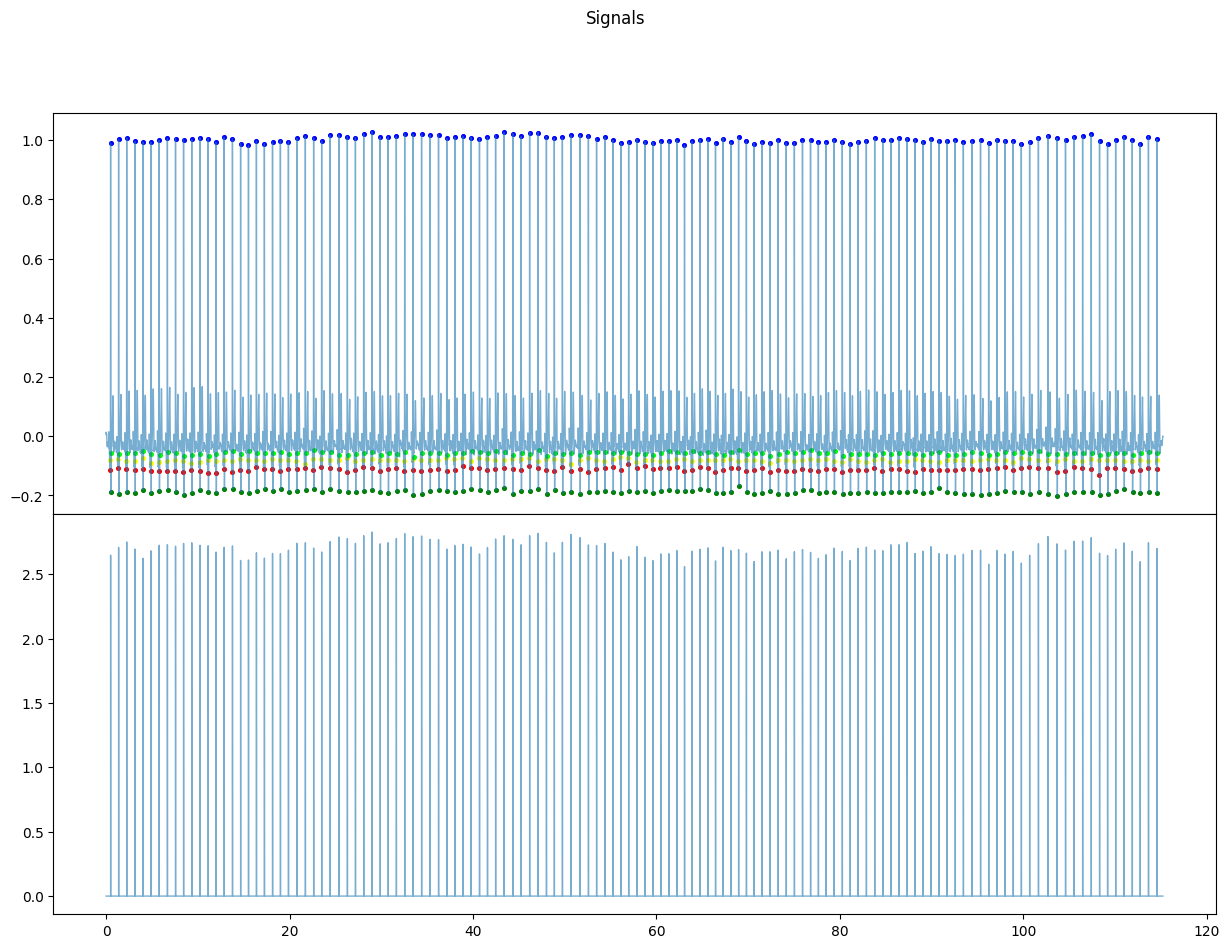

In [102]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)

plt.show()

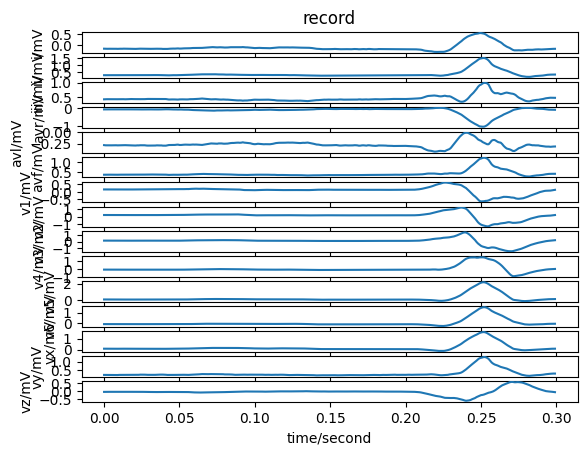

In [103]:
# Preview all channels
record = wfdb.rdrecord('../01.Dataset/117/s0291lre', sampfrom=samp_start, sampto=2300)
sample_rate = record.fs
wfdb.plot_wfdb(record, title='record')

In [104]:
print("Rx : " + str(Rx))
print("Ry : " + str(Ry))

Rx : [   495   1367   2251   3152   4024   4894   5789   6685   7571   8447
   9341  10233  11130  11991  12873  13777  14664  15523  16390  17258
  18144  19005  19878  20793  21724  22626  23501  24429  25380  26303
  27182  28084  28992  29883  30753  31642  32552  33471  34391  35316
  36240  37139  38012  38892  39790  40703  41574  42460  43385  44338
  45247  46169  47096  48001  48862  49742  50686  51658  52578  53466
  54368  55258  56112  56964  57855  58746  59603  60464  61339  62213
  63052  63888  64747  65603  66432  67261  68103  68948  69799  70637
  71491  72362  73264  74143  75030  75914  76790  77645  78492  79365
  80254  81113  81980  82876  83783  84663  85543  86426  87324  88180
  89029  89906  90789  91675  92561  93450  94379  95320  96209  97096
  97987  98884  99769 100672 101632 102665 103662 104584 105510 106449
 107389 108294 109167 110050 110963 111863 112724 113626 114552]
Ry : [0.98989802 1.00258556 1.00743372 0.99557609 0.9939313  0.9924884
 0.9995

In [105]:
print("QRS on : "+ str(qrs_on_x))
print("QRS off : "+ str(qrs_off_x))

QRS on : [   453   1325   2210   3110   3982   4853   5747   6643   7529   8406
   9299  10191  11089  11949  12831  13735  14623  15481  16349  17217
  18103  18963  19837  20752  21683  22584  23459  24387  25339  26261
  27140  28042  28951  29842  30711  31601  32510  33430  34350  35274
  36198  37098  37971  38851  39749  40662  41533  42419  43344  44296
  45206  46128  47055  47959  48820  49700  50645  51617  52537  53425
  54326  55217  56071  56923  57814  58704  59561  60423  61298  62172
  63011  63846  64706  65561  66390  67220  68062  68906  69758  70596
  71450  72321  73223  74102  74988  75873  76749  77603  78451  79323
  80212  81072  81938  82835  83742  84621  85502  86384  87283  88138
  88988  89864  90747  91634  92520  93409  94338  95279  96168  97055
  97946  98843  99728 100630 101590 102623 103621 104542 105468 106408
 107348 108252 109126 110009 110921 111822 112683 113584 114511]
QRS off : [   542   1414   2298   3198   4071   4941   5835   6732   7618 

In [106]:
# Get P wave
# Rx -> R peak location
window_size = int(fs * 0.2)  # 200 ms window
Px = []
Py = []

loc = qrs_on_x[0] # QRS onset
start_idx = int(loc - window_size)
#Py.append(max(denoised_signal[start_idx:loc])) # amplitude of P wave -> y value
#Px.append(np.argmax(denoised_signal[start_idx:loc])) # index of P wave -> x value

px = 0; py = -5
for i in range(start_idx,loc):
    if denoised_signal[i] > py:
        py = denoised_signal[i]
        px = i
print ("P wave: " + str(px) + " - " + str(py))
Py.append(py)
Px.append(px)

loc = qrs_on_x[1] # QRS onset
start_idx = int(loc - window_size)
#Py.append(max(denoised_signal[start_idx:loc])) # amplitude of P wave -> y value
#Px.append(np.argmax(denoised_signal[start_idx:loc])) # index of P wave -> x value

px = 0; py = -5
for i in range(start_idx,loc):
    if denoised_signal[i] > py:
        py = denoised_signal[i]
        px = i
print ("P wave: " + str(px) + " - " + str(py))
Py.append(py)
Px.append(px)

P wave: 312 - 0.015003047076792328
P wave: 1187 - -0.0014882970609034452


In [107]:
print("Px : " + str(Px))
print("Py : " + str(Py))

Px : [312, 1187]
Py : [0.015003047076792328, -0.0014882970609034452]


In [108]:
Px = np.array(Px)
Py = np.array(Py)

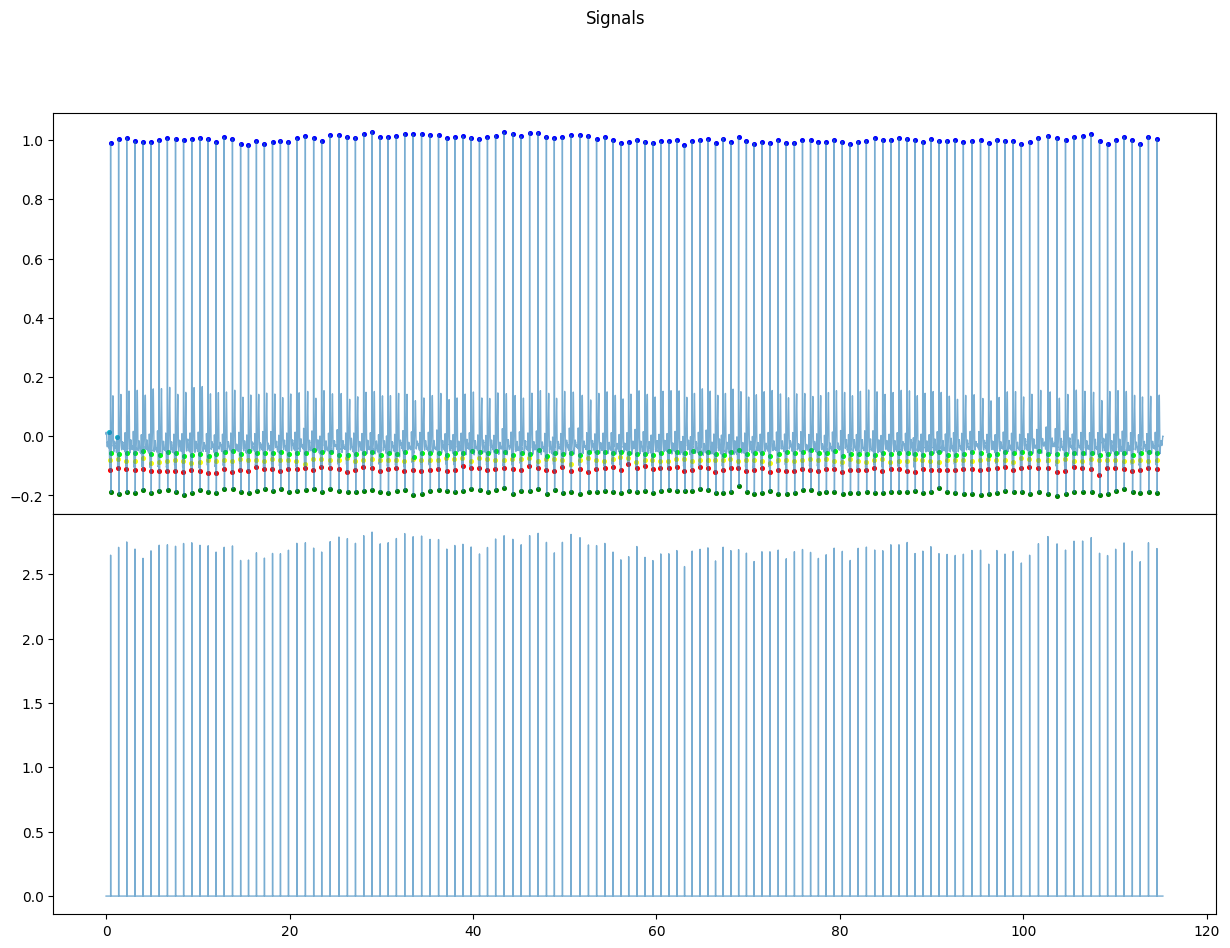

In [109]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)
axs[0].scatter(Px/fs, Py, color="#17becf", s=7)

plt.show()

In [110]:
# Get P onset and offset
p_off_x = []; p_on_x = []
p_off_y = []; p_on_y = []

for x in Px:
    X = np.array([x, denoised_signal[x]])
    Y = np.array([x-window_size, denoised_signal[x-window_size]])
    #print(X[1])
    #print(get_onset_offset(X, Y, window_smoothed_signal))
    p_on_x.append(get_onset_offset(X, Y, denoised_signal))
    p_on_y.append(denoised_signal[p_on_x[len(p_on_x)-1]])
    
    Y = np.array([x+50, denoised_signal[x+50]])
    p_off_x.append(get_onset_offset(X, Y, denoised_signal))
    p_off_y.append(denoised_signal[p_off_x[len(p_off_x)-1]])

p_on_x = np.array(p_on_x)
p_off_x = np.array(p_off_x)
p_on_y = np.array(p_on_y)
p_off_y = np.array(p_off_y)

In [111]:
print("P onset : " + str(p_on_x) + " - " + str(p_on_y))
print("P offset : " + str(p_off_x) + " - " + str(p_off_y))

P onset : [ 290 1163] - [-0.0393879  -0.05480424]
P offset : [ 338 1207] - [-0.03506173 -0.03460206]


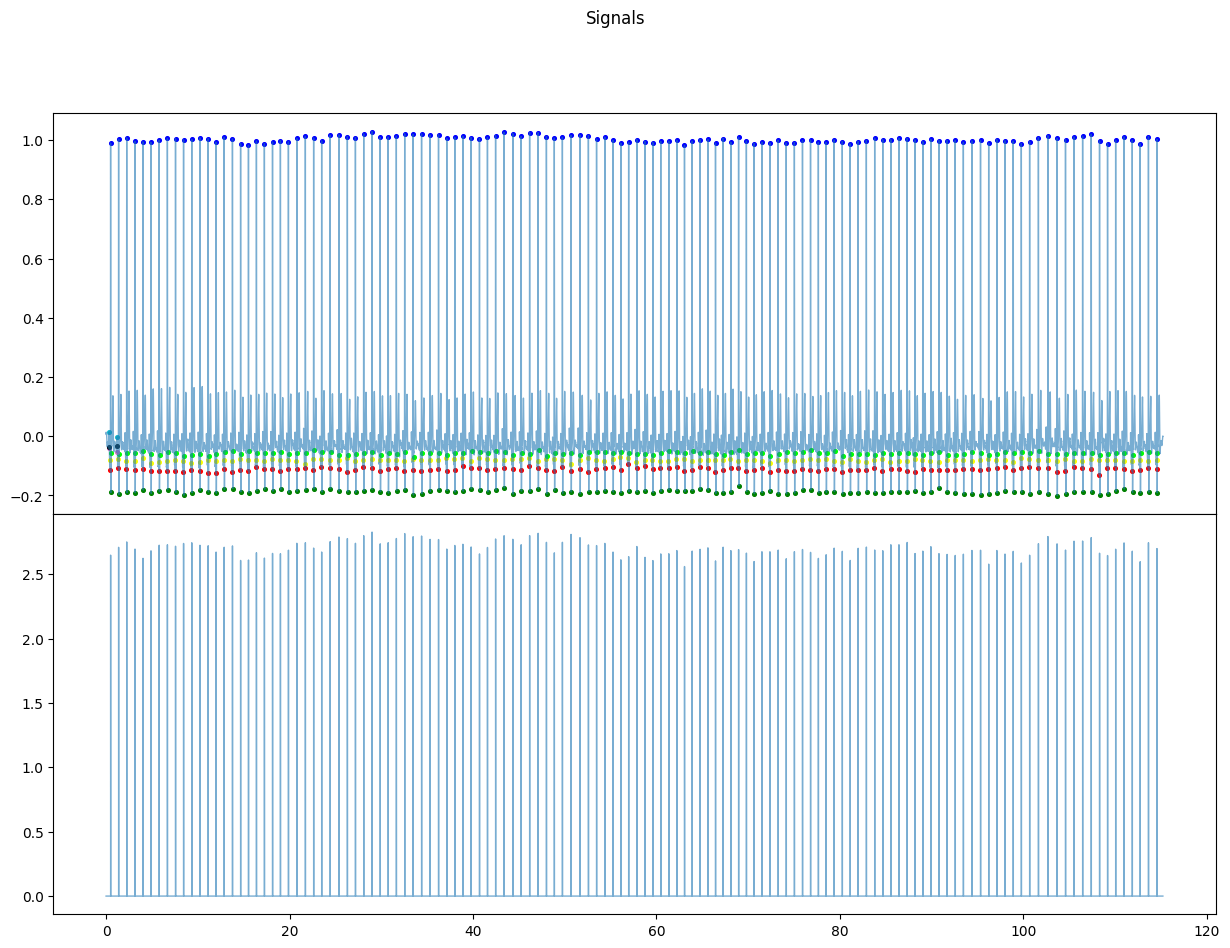

In [112]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)
axs[0].scatter(Px/fs, Py, color="#17becf", s=7)
axs[0].scatter(p_on_x/fs, p_on_y, color="#e377c2", s=7)
axs[0].scatter(p_off_x/fs, p_off_y, color="black", s=7)

plt.show()

In [113]:
window_size = int(fs * 0.4)  # 400 ms window
print(window_size)

400


In [114]:
# Get T wave
# Rx -> R peak location
window_size = int(fs * 0.4)  # 200 ms window
Tx = []
Ty = []
ws = []
tx = 0; ty = 5
loc = qrs_off_x[0]+1 # QRS offset
start_idx = int(loc + window_size)
for i in range(loc , start_idx):
    w1 = denoised_signal[i-50] - denoised_signal[i]
    w2 = denoised_signal[i] - denoised_signal[i+50]
    w = w1 * w2
    if w < ty:
        ty = w
        tx = i
        
Tx.append(tx)
Ty.append(denoised_signal[tx])


tx = 0; ty = 5
loc = qrs_off_x[1]+1 # QRS offset
start_idx = int(loc + window_size)
for i in range(loc , start_idx):
    w1 = denoised_signal[i-50] - denoised_signal[i]
    w2 = denoised_signal[i] - denoised_signal[i+50]
    w = w1 * w2
    if w < ty:
        ty = w
        tx = i
Tx.append(tx)
Ty.append(denoised_signal[tx])

In [115]:
print("Tx : " + str(Tx))
print("Ty : " + str(Ty))

Tx : [543, 1415]
Ty : [-0.0509209588476759, -0.05569808487176855]


In [116]:
Tx = np.array(Tx)
Ty = np.array(Ty)

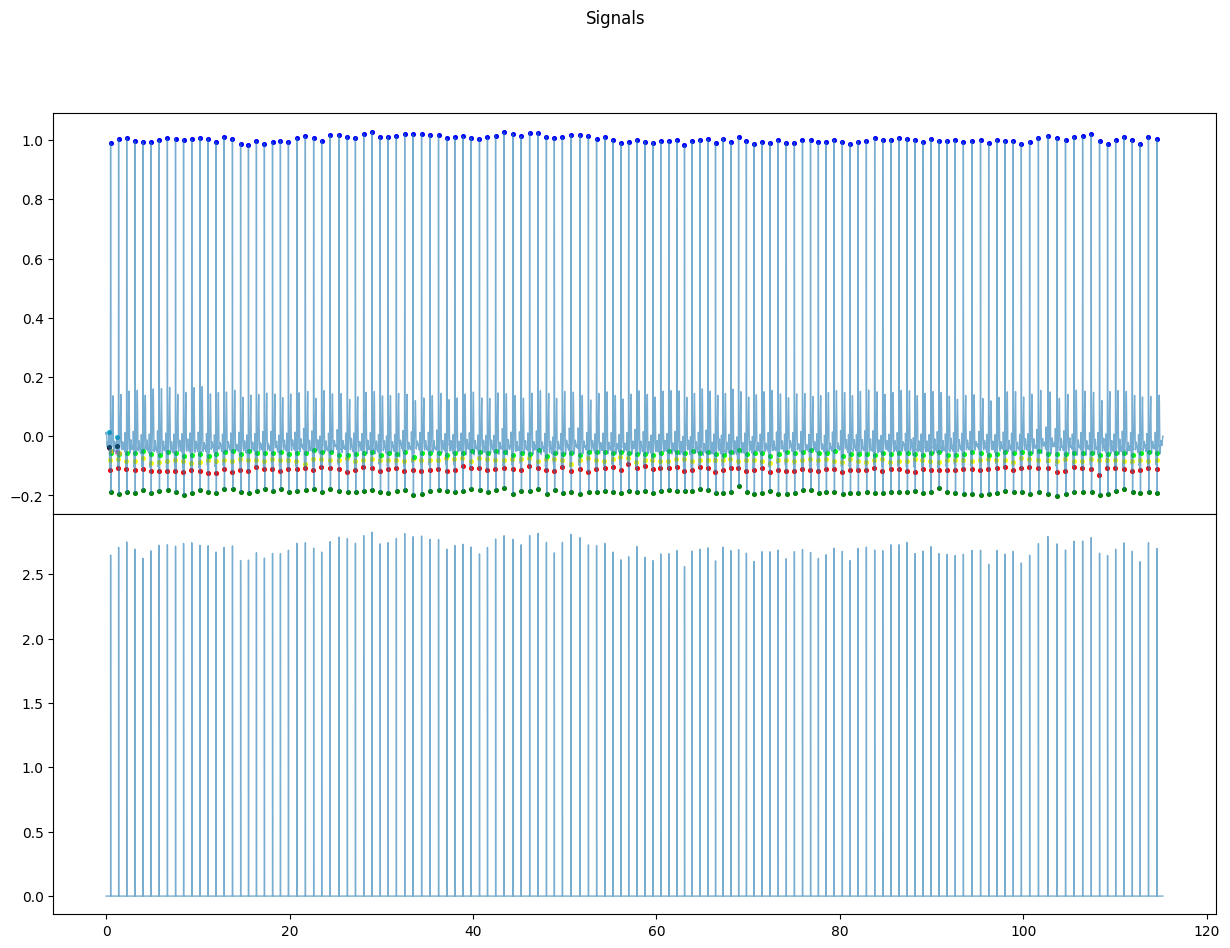

In [117]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)
axs[0].scatter(Px/fs, Py, color="#17becf", s=7)
axs[0].scatter(p_on_x/fs, p_on_y, color="#e377c2", s=7)
axs[0].scatter(p_off_x/fs, p_off_y, color="black", s=7)
axs[0].scatter(Tx/fs, Ty, color="#bcbd22", s=7)

plt.show()

In [118]:
# Get T onset and offset
t_off_x = []; t_on_x = []
t_off_y = []; t_on_y = []

for x in Tx:
    X = np.array([x, denoised_signal[x]])
    Y = np.array([x-200, denoised_signal[x-200]])
    #print(X[1])
    #print(get_onset_offset(X, Y, window_smoothed_signal))
    t_on_x.append(get_onset_offset(X, Y, denoised_signal))
    t_on_y.append(denoised_signal[t_on_x[len(t_on_x)-1]])
    
    Y = np.array([x+200, denoised_signal[x+200]])
    t_off_x.append(get_onset_offset(X, Y, denoised_signal))
    t_off_y.append(denoised_signal[t_off_x[len(t_off_x)-1]])

t_on_x = np.array(t_on_x)
t_off_x = np.array(t_off_x)
t_on_y = np.array(t_on_y)
t_off_y = np.array(t_off_y)

In [119]:
print("T onset x : " + str(t_on_x))
print("T onset y : " + str(t_on_y))
print("T offset x : " + str(t_off_x))
print("T offset y : " + str(t_off_y))

T onset x : [ 527 1399]
T onset y : [-0.18986652 -0.19636962]
T offset x : [ 644 1523]
T offset y : [-0.02154302 -0.01664087]


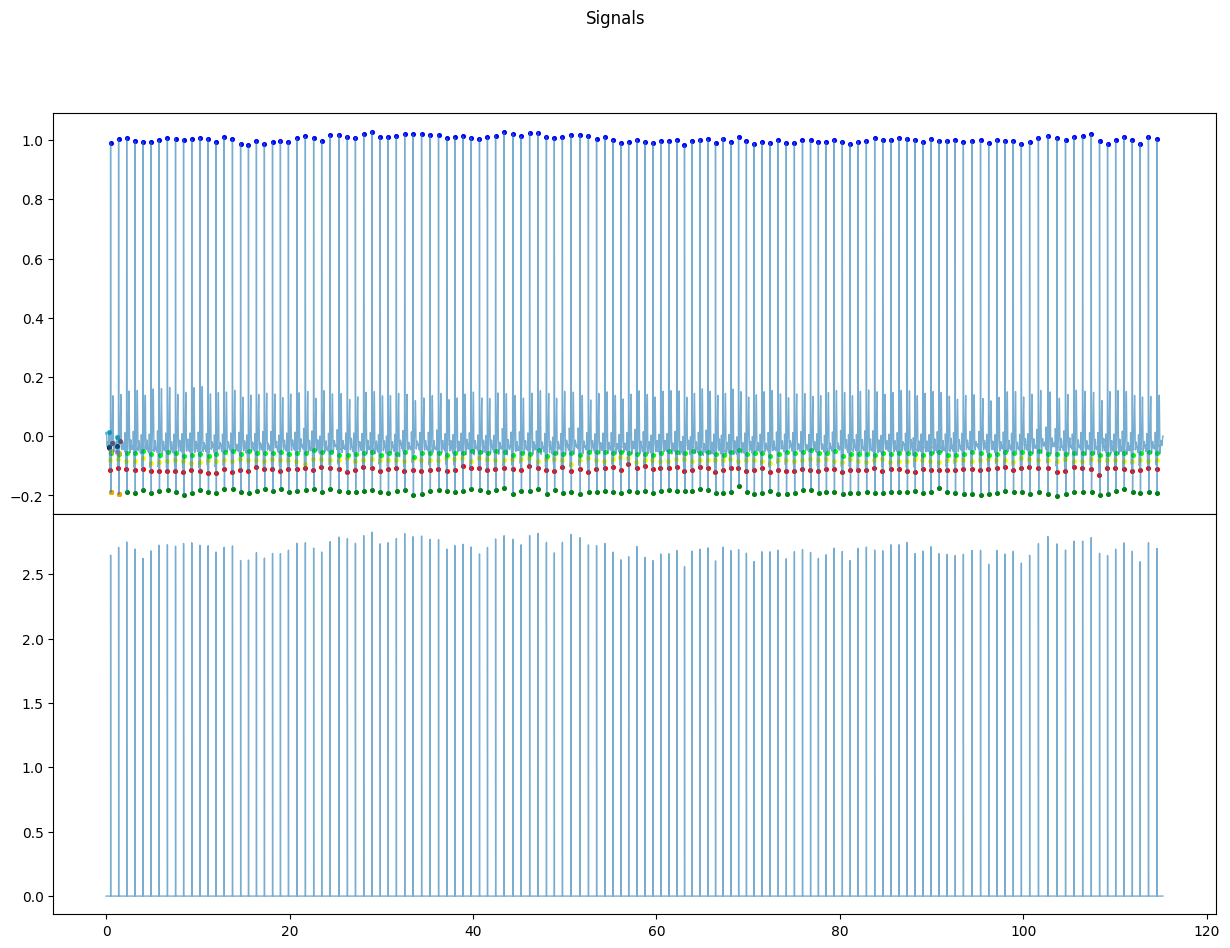

In [120]:
# Plot
ts = np.arange(0, time, 1.0 / fs)  # time vector

fig = plt.figure(figsize=[15, 10.4])
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle("Signals")
axs[0].plot(ts, denoised_signal, alpha=0.6, lw=1, label="Raw signal")
axs[1].plot(ts, y_lfiltered, alpha=0.6, lw=1, label="SciPy lfilter")

axs[0].scatter(qrs_on_x/fs, qrs_on_y, color="yellow", s=7)
axs[0].scatter(qrs_off_x/fs, qrs_off_y, color="lime", s=7)
axs[0].scatter(qx/fs, qy, color="red", s=7)
axs[0].scatter(sx/fs, sy, color="green", s=7)
axs[0].scatter(Rx/fs, Ry, color="blue", s=7)

axs[0].scatter(Px/fs, Py, color="#17becf", s=7)
axs[0].scatter(p_on_x/fs, p_on_y, color="#e377c2", s=7)
axs[0].scatter(p_off_x/fs, p_off_y, color="black", s=7)

axs[0].scatter(Tx/fs, Ty, color="#bcbd22", s=7)
axs[0].scatter(t_on_x/fs, t_on_y, color="orange", s=7)
axs[0].scatter(t_off_x/fs, t_off_y, color="brown", s=7)

plt.show()

# Non Fiducial Feature 

In [136]:
RR_previous = Rx[15]-Rx[14]
RR_next = Rx[16]-Rx[15]

nonFiducial=[]

after_Rpeak = int (2/3*((RR_previous+RR_next)/2))

for i in range( int(Rx[15]) , int(Rx[15])+after_Rpeak) :
    nonFiducial.append( denoised_signal[i])

Before_Rpeak = int (1/3*((RR_previous+RR_next)/2))

for i in range(Before_Rpeak, int(Rx[15]) ):
    nonFiducial.append( denoised_signal[i])



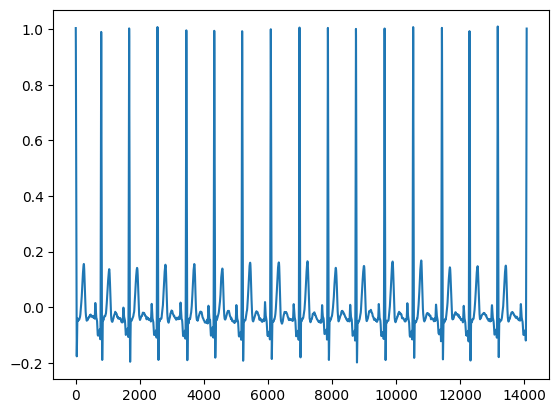

In [137]:
plt.plot(nonFiducial)

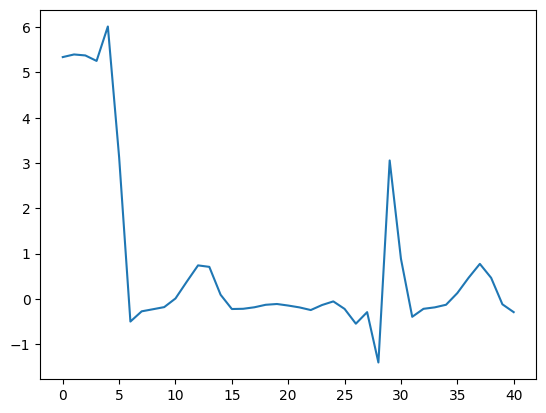

In [123]:
import pywt
import numpy as np

# Define the mother wavelet
wavelet = pywt.Wavelet('db4')

# Define the number of levels for decomposition
decomp_levels = 5

# Define the list of ECG signals
ecg_segments = np.array(nonFiducial)  # Example data

# Decompose the signal
decomp = pywt.wavedec(ecg_segments, wavelet, level=decomp_levels)

CA5,CD5,CD4,CD3,CD2,CD1 =decomp 

#only the coefficients of ECG band (1-40) use them as a feature 
non_fiducial_feature = CA5[:41]

plt.plot(non_fiducial_feature)